# LINEAR REGRESSION

In [1]:
# IMPORTING NECESSARY LIBRARIES
from formulas import *
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

keras = tf.keras

**BRIEF**

- Output = activation(dot(input, kernel) + bias

That looks familiar doesn't it? It looks almost identical to y = mx+b. The dot product is sum of the products in two sequences. Well, if there is only two sequences with a length of 1 then it is just the product of those two numbers. This simplifies down to the all to familiar y = mx + b.


## Setup

In [2]:
# Example of dot product of two sequences of length 1
np.dot(2,1) + 5

7

In [3]:
# IMPORTING NECESSARY LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

In [4]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Timestamp in Days")
    plt.ylabel("Rupees")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

def window_dataset(series, window_size, batch_size=128,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

## Forecasting with Machine Learning

First, we will train a model to forecast the next step given the previous 30 steps, therefore, we need to create a dataset of 20-step windows for training. Every 20 steps is 1 trading month since the markets are only open Sunday - Thursday which is 20 days a week.

In [5]:
# Read in data
nabil = pd.read_csv('../Data/NABILModifiedDate.csv')

# Convert series into datetime type
nabil['Date'] = pd.to_datetime(nabil['Date'])

# Save target series
series = nabil['Close']

# Create train data set
train_split_date = '2019-12-31'
train_split_index = np.where(nabil.Date == train_split_date)[0][0]
x_train = nabil.loc[nabil['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2021-01-03'
test_split_index = np.where(nabil.Date == test_split_date)[0][0]
x_test = nabil.loc[nabil['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = nabil.loc[(nabil['Date'] < test_split_date) & (nabil['Date'] > train_split_date)]['Close']

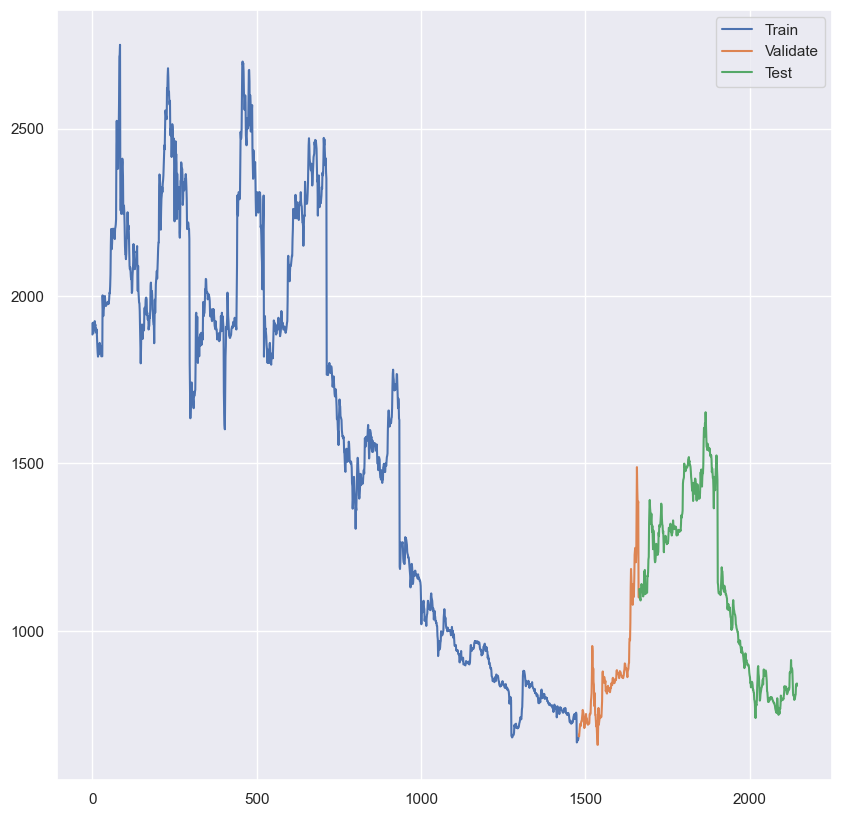

1479 1480 1663 1664 2144


<Figure size 1000x1000 with 0 Axes>

In [6]:
# Plot all lines on one chart to see where one segment starts and another ends
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.legend()
plt.show()
plt.savefig('../Images/LINEAR/LINEAR REGRESSION TRAIN TEST SPLIT')
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [7]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
nabil_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

### Linear Model

In [8]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Clears any background saved info useful in notebooks
keras.backend.clear_session()

# Make reproducible
tf.random.set_seed(42)
np.random.seed(42)

# set window size 
window_size = 20

# define training data (20 day windows shifted by 1 every time)
train_set = window_dataset(normalized_x_train.flatten(), window_size)

# Build Linear Model of a single dense layer
model = keras.models.Sequential([
    keras.layers.Dense(1, input_shape=[window_size])
])

# Find optimal learning rate
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.legacy.Nadam(learning_rate=1e-6)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Fit the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
12/12 [==============================] - 1s 38ms/step - loss: 0.0952 - mae: 0.3678 - lr: 1.0000e-06
Epoch 2/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0951 - mae: 0.3677 - lr: 1.0798e-06
Epoch 3/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0951 - mae: 0.3676 - lr: 1.1659e-06
Epoch 4/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0950 - mae: 0.3674 - lr: 1.2589e-06
Epoch 5/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0949 - mae: 0.3673 - lr: 1.3594e-06
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 0.0949 - mae: 0.3671 - lr: 1.4678e-06
Epoch 7/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0948 - mae: 0.3669 - lr: 1.5849e-06
Epoch 8/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0947 - mae: 0.3667 - lr: 1.7113e-06
Epoch 9/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0946 - mae: 0.3665 - lr: 1.8478e-06


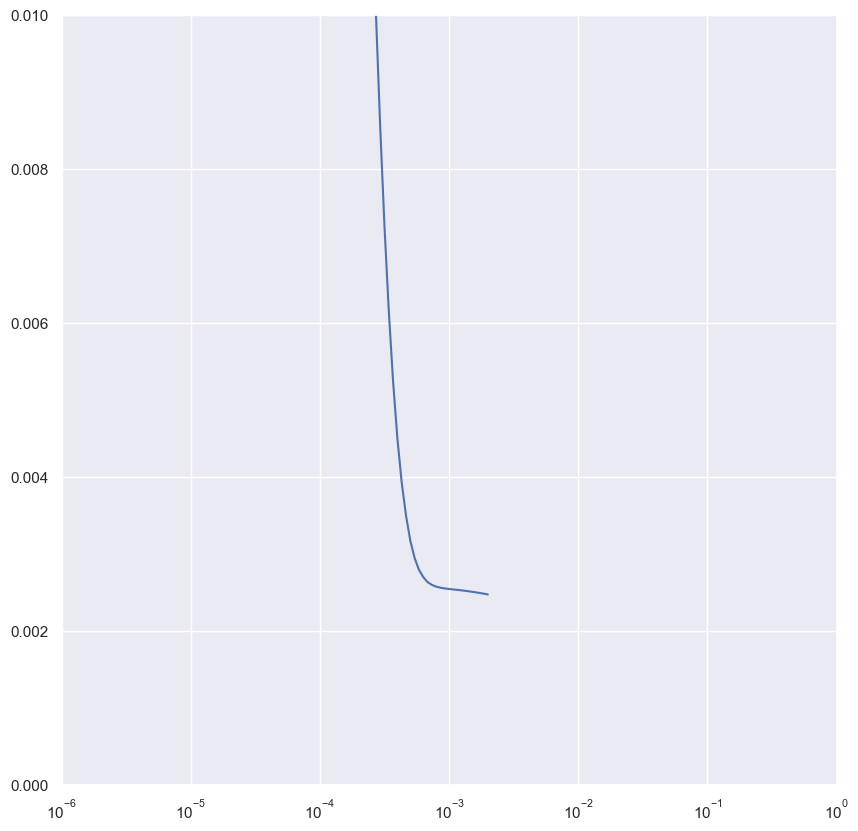

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1, 0, .01])
plt.savefig('../Images/LINEAR/LINEAR REGRESSION LEARNING RATE')

In [10]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Useful to clear everything when rerunning cells
keras.backend.clear_session()

# Make this reproducible
tf.random.set_seed(42)
np.random.seed(42)

# Create train and validate windows
window_size = 20
train_set = window_dataset(normalized_x_train.flatten(), window_size)
valid_set = window_dataset(normalized_x_valid.flatten(), window_size)

# 1 layer producing linear output for 1 output from each window of 20 days
model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size]) # o
])

# Huber works well with "mae"
optimizer = tf.keras.optimizers.legacy.Nadam(learning_rate=1e-3)  # Use the legacy Nadam optimizer with learning_rate argument
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# create save points for best model
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

# Set up early stop
early_stopping = keras.callbacks.EarlyStopping(patience=20)

# fit model to data
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])


Epoch 1/500
      1/Unknown - 0s 357ms/step - loss: 0.3072 - mae: 0.7304INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 1s 37ms/step - loss: 0.2146 - mae: 0.5488 - val_loss: 0.0120 - val_mae: 0.1191
Epoch 2/500
 1/12 [=>............................] - ETA: 0s - loss: 0.2154 - mae: 0.6112INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.1515 - mae: 0.4554 - val_loss: 0.0082 - val_mae: 0.0935
Epoch 3/500
 1/12 [=>............................] - ETA: 0s - loss: 0.1593 - mae: 0.5215INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0971 - mae: 0.3588 - val_loss: 0.0054 - val_mae: 0.0722
Epoch 4/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0847 - mae: 0.3751INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 21ms/step - loss: 0.0587 - mae: 0.2728 - val_loss: 0.0036 - val_mae: 0.0557
Epoch 5/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0584 - mae: 0.3060INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0339 - mae: 0.2023 - val_loss: 0.0026 - val_mae: 0.0457
Epoch 6/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0346 - mae: 0.2271INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 19ms/step - loss: 0.0192 - mae: 0.1499 - val_loss: 0.0021 - val_mae: 0.0435
Epoch 7/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0185 - mae: 0.1633INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 19ms/step - loss: 0.0112 - mae: 0.1140 - val_loss: 0.0018 - val_mae: 0.0452
Epoch 8/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0105 - mae: 0.1189INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0070 - mae: 0.0899 - val_loss: 0.0017 - val_mae: 0.0470
Epoch 9/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0060 - mae: 0.0861INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 19ms/step - loss: 0.0051 - mae: 0.0759 - val_loss: 0.0017 - val_mae: 0.0485
Epoch 10/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0057 - mae: 0.0827INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0042 - mae: 0.0688 - val_loss: 0.0017 - val_mae: 0.0494
Epoch 11/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0049 - mae: 0.0751INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0039 - mae: 0.0656 - val_loss: 0.0017 - val_mae: 0.0498
Epoch 12/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0041 - mae: 0.0669INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0037 - mae: 0.0644 - val_loss: 0.0017 - val_mae: 0.0499
Epoch 13/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0036 - mae: 0.0624INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 29ms/step - loss: 0.0037 - mae: 0.0638 - val_loss: 0.0017 - val_mae: 0.0498
Epoch 14/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0046 - mae: 0.0686INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0036 - mae: 0.0634 - val_loss: 0.0017 - val_mae: 0.0496
Epoch 15/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0060 - mae: 0.0763INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 19ms/step - loss: 0.0036 - mae: 0.0632 - val_loss: 0.0017 - val_mae: 0.0492
Epoch 16/500
 1/12 [=>............................] - ETA: 1s - loss: 0.0046 - mae: 0.0698INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0036 - mae: 0.0628 - val_loss: 0.0016 - val_mae: 0.0489
Epoch 17/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0034 - mae: 0.0618INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 19ms/step - loss: 0.0036 - mae: 0.0626 - val_loss: 0.0016 - val_mae: 0.0484
Epoch 18/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0045 - mae: 0.0703INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0036 - mae: 0.0622 - val_loss: 0.0016 - val_mae: 0.0480
Epoch 19/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0035 - mae: 0.0622INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0035 - mae: 0.0619 - val_loss: 0.0016 - val_mae: 0.0476
Epoch 20/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0038 - mae: 0.0645INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 19ms/step - loss: 0.0035 - mae: 0.0616 - val_loss: 0.0016 - val_mae: 0.0472
Epoch 21/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0035 - mae: 0.0597INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0035 - mae: 0.0613 - val_loss: 0.0016 - val_mae: 0.0467
Epoch 22/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0040 - mae: 0.0606INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0035 - mae: 0.0609 - val_loss: 0.0015 - val_mae: 0.0463
Epoch 23/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0038 - mae: 0.0660INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0035 - mae: 0.0606 - val_loss: 0.0015 - val_mae: 0.0459
Epoch 24/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0044 - mae: 0.0635INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0034 - mae: 0.0602 - val_loss: 0.0015 - val_mae: 0.0454
Epoch 25/500
 1/12 [=>............................] - ETA: 1s - loss: 0.0044 - mae: 0.0644INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0034 - mae: 0.0599 - val_loss: 0.0015 - val_mae: 0.0450
Epoch 26/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0043 - mae: 0.0671INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0034 - mae: 0.0595 - val_loss: 0.0015 - val_mae: 0.0446
Epoch 27/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0037 - mae: 0.0610INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0034 - mae: 0.0592 - val_loss: 0.0015 - val_mae: 0.0442
Epoch 28/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0029 - mae: 0.0598INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 21ms/step - loss: 0.0033 - mae: 0.0588 - val_loss: 0.0014 - val_mae: 0.0437
Epoch 29/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0038 - mae: 0.0613INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0033 - mae: 0.0585 - val_loss: 0.0014 - val_mae: 0.0433
Epoch 30/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0049 - mae: 0.0697INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0033 - mae: 0.0582 - val_loss: 0.0014 - val_mae: 0.0429
Epoch 31/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0057 - mae: 0.0776INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 21ms/step - loss: 0.0033 - mae: 0.0578 - val_loss: 0.0014 - val_mae: 0.0424
Epoch 32/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0042 - mae: 0.0644INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0033 - mae: 0.0574 - val_loss: 0.0014 - val_mae: 0.0420
Epoch 33/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0042 - mae: 0.0664INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 27ms/step - loss: 0.0032 - mae: 0.0571 - val_loss: 0.0014 - val_mae: 0.0415
Epoch 34/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0022 - mae: 0.0471INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0032 - mae: 0.0567 - val_loss: 0.0014 - val_mae: 0.0412
Epoch 35/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0053 - mae: 0.0731INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0032 - mae: 0.0564 - val_loss: 0.0014 - val_mae: 0.0408
Epoch 36/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0038 - mae: 0.0618INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0032 - mae: 0.0561 - val_loss: 0.0014 - val_mae: 0.0404
Epoch 37/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0047 - mae: 0.0672INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0032 - mae: 0.0557 - val_loss: 0.0014 - val_mae: 0.0401
Epoch 38/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0042 - mae: 0.0645INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0031 - mae: 0.0555 - val_loss: 0.0014 - val_mae: 0.0397
Epoch 39/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0040 - mae: 0.0611INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0031 - mae: 0.0551 - val_loss: 0.0013 - val_mae: 0.0393
Epoch 40/500
 4/12 [=========>....................] - ETA: 0s - loss: 0.0042 - mae: 0.0629INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 32ms/step - loss: 0.0031 - mae: 0.0548 - val_loss: 0.0013 - val_mae: 0.0389
Epoch 41/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0037 - mae: 0.0603INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 22ms/step - loss: 0.0031 - mae: 0.0544 - val_loss: 0.0013 - val_mae: 0.0386
Epoch 42/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0034 - mae: 0.0586INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0031 - mae: 0.0542 - val_loss: 0.0013 - val_mae: 0.0383
Epoch 43/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0041 - mae: 0.0645INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0031 - mae: 0.0538 - val_loss: 0.0013 - val_mae: 0.0380
Epoch 44/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0035 - mae: 0.0547INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 19ms/step - loss: 0.0030 - mae: 0.0535 - val_loss: 0.0013 - val_mae: 0.0376
Epoch 45/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0046 - mae: 0.0704INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0030 - mae: 0.0532 - val_loss: 0.0013 - val_mae: 0.0373
Epoch 46/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0039 - mae: 0.0605INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0030 - mae: 0.0529 - val_loss: 0.0013 - val_mae: 0.0371
Epoch 47/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0043 - mae: 0.0628INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0030 - mae: 0.0526 - val_loss: 0.0013 - val_mae: 0.0368
Epoch 48/500
 1/12 [=>............................] - ETA: 1s - loss: 0.0042 - mae: 0.0637INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0030 - mae: 0.0523 - val_loss: 0.0013 - val_mae: 0.0365
Epoch 49/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0028 - mae: 0.0558INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 21ms/step - loss: 0.0029 - mae: 0.0520 - val_loss: 0.0013 - val_mae: 0.0363
Epoch 50/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0034 - mae: 0.0605INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0029 - mae: 0.0517 - val_loss: 0.0013 - val_mae: 0.0360
Epoch 51/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0034 - mae: 0.0543INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


12/12 [==============================] - 0s 20ms/step - loss: 0.0029 - mae: 0.0515 - val_loss: 0.0013 - val_mae: 0.0358
Epoch 52/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0029 - mae: 0.0512 - val_loss: 0.0013 - val_mae: 0.0355
Epoch 53/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0029 - mae: 0.0509 - val_loss: 0.0013 - val_mae: 0.0353
Epoch 54/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0029 - mae: 0.0506 - val_loss: 0.0013 - val_mae: 0.0351
Epoch 55/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0029 - mae: 0.0504 - val_loss: 0.0013 - val_mae: 0.0350
Epoch 56/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0028 - mae: 0.0502 - val_loss: 0.0013 - val_mae: 0.0348
Epoch 57/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0028 - mae: 0.0498 - val_loss: 0.0013 - val_mae: 0.0347
Epoch 58/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0028 - mae: 

In [11]:
lin_forecast = model_forecast(model, nabil_normalized_to_traindata.flatten()[x_test.index.min() - window_size:-1], window_size)[:, 0]

16/16 [==============================] - 0s 3ms/step


In [12]:
# Undo the scaling
lin_forecast = x_train_scaler.inverse_transform(lin_forecast.reshape(-1,1)).flatten()
lin_forecast.shape

(481,)

/var/folders/7c/1rzbrtxj2s3bn1b6l1dklf8w0000gn/T/ipykernel_8586/3700672476.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(time[start:end], series[start:end], format, label=label)


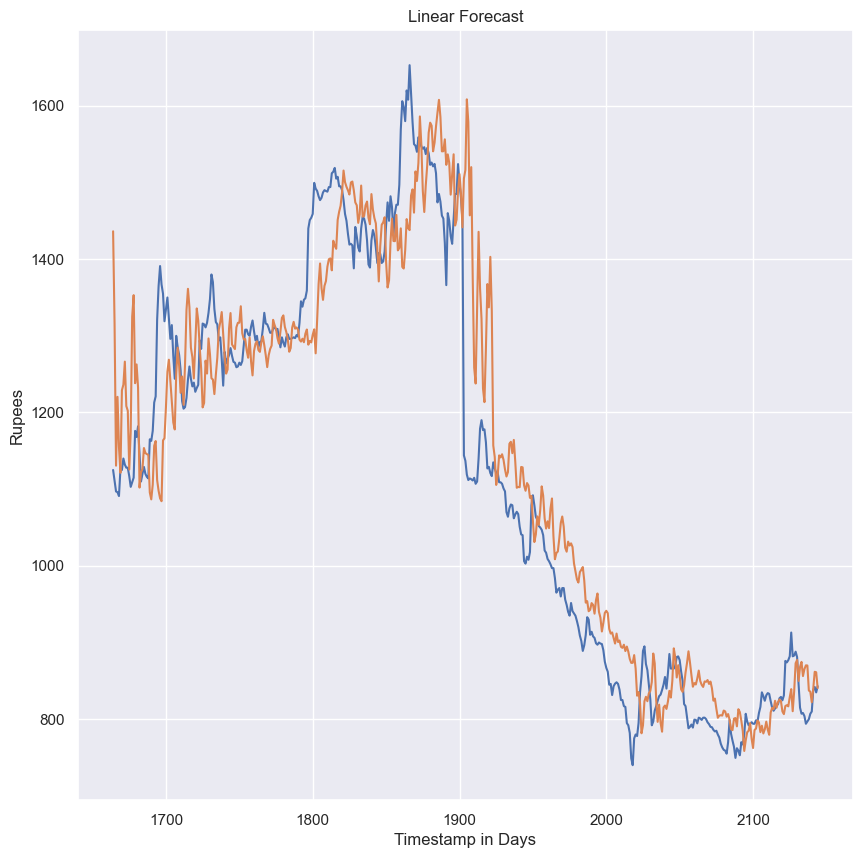

MAE ERROR FOR LINEAR FORECAST IS: 64.8263168334961


<Figure size 1000x1000 with 0 Axes>

In [13]:
# Plot results
plt.title('Linear Forecast')
plt.ylabel('RUPEES')
plt.xlabel('Timestep in Days')
plot_series(x_test.index, x_test)
plot_series(x_test.index, lin_forecast)
plt.show()
plt.savefig('../Images/LINEAR/LINEAR REGRESSION FORECAST 80-20 DISTRIBUTION')

linear_mae = keras.metrics.mean_absolute_error(x_test, lin_forecast).numpy()
print(f"MAE ERROR FOR LINEAR FORECAST IS: {linear_mae}")

#### Linear Model Result

In [14]:
linear_mae = keras.metrics.mean_absolute_error(x_test, lin_forecast).numpy()
print(linear_mae)

64.82632
